Analysis of Enron Data. Based on Udacity intro to machine learning course

email data can be found at: https://www.cs.cmu.edu/~./enron/enron_mail_20150507.tgz
and 'data/emails_by_address/'
financial data can be found in 'financial_data.pdf' in this repository

In [4]:
# Suppress package warnings, most of which are caused by deprecations
import warnings
warnings.filterwarnings('ignore')

In [5]:
### Load the dictionary containing financial data and some email features (to_ from_poi)
import pickle
with open('data/final_project_dataset.pkl', 'rb') as f:
    fin_data_dict = pickle.load(f)

# Remove outliers
fin_data_dict.pop('TOTAL', 0)

# Store to my_dataset for easy export below.
my_dataset = fin_data_dict


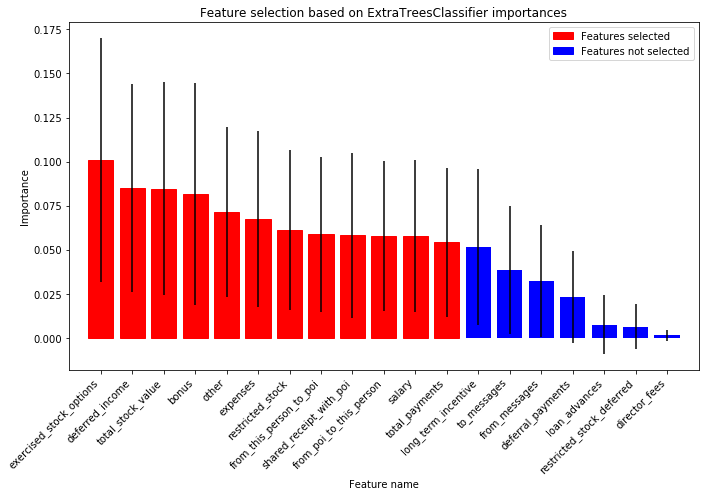

In [6]:
### Select features to use

# features_list is a list of feature names in the financial data.
# The first feature must be "poi".

import numpy as np
from tools.feature_format import featureFormat, targetFeatureSplit

def make_features_labels(dataset, feature_names):
    """
    Quick way to split a dataset into features and labels based on feature names
    """
    data = featureFormat(dataset, feature_names, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    labels = np.array(labels)
    features = np.array(features)
    
    return features, labels

# Start with all features except: 'email_address'

all_feature_names = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',\
'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi',\
'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances',\
'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',\
'long_term_incentive', 'from_poi_to_this_person']

all_features, all_labels = make_features_labels(my_dataset, all_feature_names)

# Select the most important features based on ExtraTreesClassifier
from feature_selection import importance_plotter
selected_feature_names = importance_plotter(all_features, all_labels, 
                                            np.array(all_feature_names[1:]))

In [7]:
### Confirm that the feature selection did help performance:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Make features and labels based on the new selection
selected_feature_names.insert(0, 'poi')
selected_features, selected_labels = make_features_labels(my_dataset, selected_feature_names)

clf = GaussianNB()
def fit_print_scores(clf, features, labels):

    f1_scores = cross_val_score(clf, features, labels, cv=5, scoring='f1')
    print '-f1 score: %0.2f (+/- %0.2f)' % (f1_scores.mean(), 
                                           f1_scores.std() * 2)
    precision_scores = cross_val_score(clf, features, labels, cv=5, scoring='precision')
    print '-precision score: %0.2f (+/- %0.2f)' % (precision_scores.mean(), 
                                                  precision_scores.std() * 2)
    recall_scores = cross_val_score(clf, features, labels, cv=5, scoring='recall')
    print '-recall score: %0.2f (+/- %0.2f)' % (recall_scores.mean(), 
                                                  recall_scores.std() * 2)

print 'All features:'
fit_print_scores(clf, all_features, all_labels)
print '\nSelected features:'
fit_print_scores(clf, selected_features, selected_labels)

All features:
-f1 score: 0.24 (+/- 0.27)
-precision score: 0.19 (+/- 0.24)
-recall score: 0.42 (+/- 0.52)

Selected features:
-f1 score: 0.31 (+/- 0.38)
-precision score: 0.35 (+/- 0.45)
-recall score: 0.28 (+/- 0.33)


Looks like this feature selection approach does not really improve performance, especially since the recall score suffers a lot. 

Try again, but this time selecting features by training the decision trees that determine feature importance on a data set with equal amounts of pois and non-pois. This should address imbalanced trees that are biased towards non-pois. 

In [8]:
from balanced_trees import data_balancer
from sklearn.model_selection import train_test_split
train_bal_features, _, train_bal_labels, _ = train_test_split(all_features, all_labels, 
                                                    test_size=0.3, random_state=42)

balanced_features, balanced_labels = data_balancer(train_bal_features, train_bal_labels)

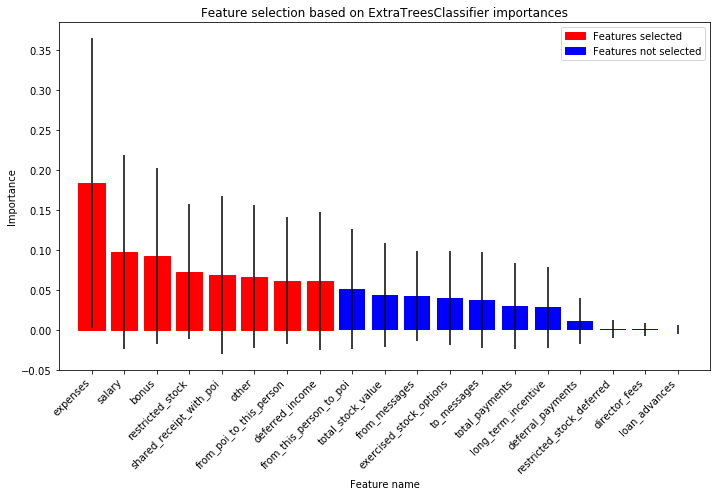

In [9]:
balanced_selected_feature_names = importance_plotter(balanced_features, balanced_labels, 
                                                     np.array(all_feature_names[1:]))

In [10]:
balanced_selected_feature_names.insert(0, 'poi')
balanced_selected_features, balanced_selected_labels = \
    make_features_labels(my_dataset, balanced_selected_feature_names)
    
print 'All features:'
fit_print_scores(clf, all_features, all_labels)
print '\nSelected features after balancing:'
fit_print_scores(clf, balanced_selected_features, balanced_selected_labels)

All features:
-f1 score: 0.24 (+/- 0.27)
-precision score: 0.19 (+/- 0.24)
-recall score: 0.42 (+/- 0.52)

Selected features after balancing:
-f1 score: 0.30 (+/- 0.10)
-precision score: 0.33 (+/- 0.18)
-recall score: 0.28 (+/- 0.08)


This seems better, at least the recal score doesn't suffer as much and the f1 and precision scores are still decent.The confidence intervals have also gotten smaller.

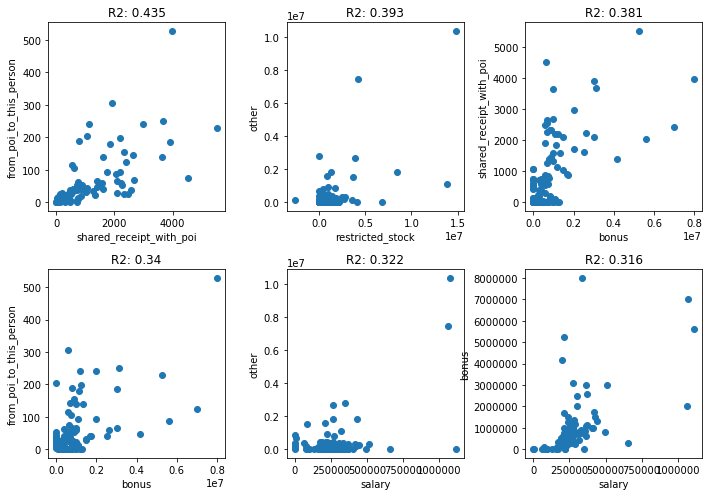

In [19]:
# Plot the most highly correlated features to see if there is any redundancy or outliers 
from feature_selection import correlation_plotter
correlation_plotter(balanced_selected_feature_names[1:], my_dataset)

From the correlation graphs it seems like there is not much redundancy in the selected features.

In [22]:
### Create new features
# word_dict_subset is a dictionary that contains emails from all of the people
# with financial data AND email data available separated into 'to' and 'from categories. 
# 86 people total, 14 pois

import pickle
with open('data/word_dict_subset.pkl', 'rb') as f:
    data_text = pickle.load(f)

#Separate data into emails from, to, or all-together
from tools.email_analysis import email_list_and_labels
to_emails, to_email_labels = email_list_and_labels(data_text, 'to')
from_emails, from_email_labels = email_list_and_labels(data_text, 'from')
all_emails, all_email_labels = email_list_and_labels(data_text, 'all')

# Create a tf-idf vectors of each person's to, from, and all-together emails
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)

to_feature_matrix = vectorizer.fit_transform(to_emails)
from_feature_matrix = vectorizer.fit_transform(from_emails)
all_feature_matrix = vectorizer.fit_transform(all_emails)

In [23]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
print 'To emails scores:'
fit_print_scores(clf, to_feature_matrix.toarray(), to_email_labels)
print '\nFrom emails scores:'
fit_print_scores(clf, from_feature_matrix.toarray(), from_email_labels)
print '\nAll emails scores:'
fit_print_scores(clf, all_feature_matrix.toarray(), all_email_labels)

To emails scores:
-f1 score: 0.00 (+/- 0.00)
-precision score: 0.00 (+/- 0.00)
-recall score: 0.00 (+/- 0.00)

From emails scores:
-f1 score: 0.00 (+/- 0.00)
-precision score: 0.00 (+/- 0.00)
-recall score: 0.00 (+/- 0.00)

All emails scores:
-f1 score: 0.00 (+/- 0.00)
-precision score: 0.00 (+/- 0.00)
-recall score: 0.00 (+/- 0.00)


Looks like email word extraction does not yield very promising results, will drop for now.

In [18]:
### Try a variety of classifiers

# for ease rename balanced_selected_features and balanced_selected_labels
features = balanced_selected_features
labels = balanced_selected_labels

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
print 'Gaussian naive Bayes:'
fit_print_scores(clf, features, labels)

from sklearn.svm import SVC 
clf = SVC()
print '\nSupport vector machine:'
fit_print_scores(clf, features, labels)

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
clf = RandomForestClassifier()
print '\nRandom forest:'
fit_print_scores(clf, features, labels)

clf = ExtraTreesClassifier()
print '\nExtra trees:'
fit_print_scores(clf, features, labels)

clf = AdaBoostClassifier()
print '\nAdaBoost:'
fit_print_scores(clf, features, labels)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
print('\nLogistic regression:')
fit_print_scores(clf, features, labels)

Gaussian naive Bayes:
-f1 score: 0.30 (+/- 0.10)
-precision score: 0.33 (+/- 0.18)
-recall score: 0.28 (+/- 0.08)

Support vector machine:
-f1 score: 0.00 (+/- 0.00)
-precision score: 0.00 (+/- 0.00)
-recall score: 0.00 (+/- 0.00)

Random forest:
-f1 score: 0.17 (+/- 0.42)
-precision score: 0.20 (+/- 0.49)
-recall score: 0.23 (+/- 0.24)

Extra trees:
-f1 score: 0.07 (+/- 0.27)
-precision score: 0.10 (+/- 0.40)
-recall score: 0.17 (+/- 0.28)

AdaBoost:
-f1 score: 0.48 (+/- 0.17)
-precision score: 0.62 (+/- 0.47)
-recall score: 0.43 (+/- 0.16)

Logistic regression:
-f1 score: 0.04 (+/- 0.18)
-precision score: 0.04 (+/- 0.16)
-recall score: 0.05 (+/- 0.20)


The most promising classifiers are:
AdaBoost, Naive Bayes, and Random Forest. Will tune parameters for these. 

In [ ]:
### Tune classifier to achieve better than .3 precision and recall 

# Example starting point. Try investigating other evaluation techniques!


In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
from tools.tester import dump_classifier_and_data

dump_classifier_and_data(clf, my_dataset, features_list)